# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import scipy.stats

from pathlib import Path
from Bio import Phylo
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


import warnings
warnings.filterwarnings('ignore')

# Data

In [45]:
Data_folder = Path("results/")
Figures_folder = Path("Figures")
Figures_folder.mkdir(parents=True, exist_ok=True)


stats_df_path = Data_folder / "stats_ESC_GA4805AA.csv"
aa_site_df_path = Data_folder / "mutants_sites_ESC_GA4805AA.csv"
scores_df_path = Data_folder / "scores_subset.csv"
full_seq_df_path = Data_folder / "full_seq_single_muts.csv"
double_muts_df_path = Data_folder / "double_mut_epistasis.csv"
ipr_df_path = Data_folder / "IPR.csv"
couplings_df_path = Data_folder / "couplings.csv"
simulated_sites_df_path = Data_folder / "simulated_sites_ESC_GA4805AA.csv"

# Figure parameters

In [46]:
linewidth = 1
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
DPI = 300
WIDTH = 3.5
HW_RATIO = 2/3

def parameters():
    plt.rc('font', size=SMALL_SIZE, family='sans-serif') 
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('legend', title_fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

color_variable = sns.color_palette("colorblind")[0]
color_conserved = sns.color_palette("Set2")[4]
color_alw_var = "#1E90FF"
color_alw_conserved = "#ADFF2F" #sns.color_palette("Paired")[2]
color_cont_conserved = "#196f3d" #sns.color_palette("Paired")[3]
color_dca = sns.color_palette("Paired")[5]
color_ind = sns.color_palette("Set2")[5]
color_rand = sns.color_palette("tab10")[7]

# Analysis parameters

In [47]:
prop_gaps = 0.2

# Clean dataframes

In [49]:
stats_df = pd.read_csv(stats_df_path)
stats_df = stats_df[(stats_df["Prop_gaps_local"]<prop_gaps) & (stats_df["Prop_gaps_distant"]<prop_gaps)]
stats_df["IG"] = stats_df["CI_Entropy"]-stats_df["CD_Entropy"]

aa_site_df = pd.read_csv(aa_site_df_path)
aa_site_df = stats_df[["Gene","Locus"]].merge(aa_site_df,how="left")
aa_site_df = aa_site_df.sort_values(by=["Gene","Locus","DCA_score"])
aa_site_df["Rank_DCA"] = [i for i in range(20)]*len(aa_site_df[["Gene","Locus"]].drop_duplicates())
aa_site_df = aa_site_df.sort_values(by=["Gene","Locus","Profile"], ascending=[True,True,False])
aa_site_df["Rank_Ind"] = [i for i in range(20)]*len(aa_site_df[["Gene","Locus"]].drop_duplicates())
aa_site_df = stats_df[["Gene","Locus","CD_Entropy"]].merge(aa_site_df)
aa_site_df["exp_DCA"] = np.exp(-aa_site_df["DCA_score"])
norm = aa_site_df[["Gene","Locus","exp_DCA"]].groupby(["Gene","Locus"]).sum().reset_index()
norm.columns = ["Gene","Locus","Norm"]
aa_site_df = aa_site_df.merge(norm, on=["Gene","Locus"])
aa_site_df["DCA_Proba"] = aa_site_df["exp_DCA"]/aa_site_df["Norm"]
columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile','Accessible', 'DCA_score', 'Rank_DCA', 'Rank_Ind', 'DCA_Proba']
aa_site_df = aa_site_df[columns]
aa_site_df["acc_DCA_Proba"] = aa_site_df["DCA_Proba"]*(aa_site_df["Accessible"]).astype(int)
norm = aa_site_df[["Gene","Locus","acc_DCA_Proba"]].groupby(["Gene","Locus"]).sum().reset_index()
norm.columns = ["Gene","Locus","Norm"]
aa_site_df = aa_site_df.merge(norm, on=["Gene","Locus"])
aa_site_df["acc_DCA_Proba"] = aa_site_df["acc_DCA_Proba"]/aa_site_df["Norm"]
columns += ["acc_DCA_Proba"]
aa_site_df = aa_site_df[columns]
aa_site_df["acc_Profile"] = aa_site_df["Profile"]*(aa_site_df["Accessible"]).astype(int)
norm = aa_site_df[["Gene","Locus","acc_Profile"]].groupby(["Gene","Locus"]).sum().reset_index()
norm.columns = ["Gene","Locus","Norm"]
aa_site_df = aa_site_df.merge(norm, on=["Gene","Locus"])
aa_site_df["acc_Profile"] = aa_site_df["acc_Profile"]/aa_site_df["Norm"]
columns += ["acc_Profile"]
aa_site_df = aa_site_df[columns]

couplings_df = pd.read_csv(couplings_df_path)
couplings_df = stats_df[["Gene","Locus"]].merge(couplings_df, right_on=["Gene","i"], left_on=["Gene", "Locus"],how="inner").merge(stats_df[["Gene","Locus"]], left_on=["Gene","k"], right_on=["Gene", "Locus"],how="inner")
couplings_df = couplings_df[(couplings_df["AAi1"]!="-") & (couplings_df["AAi2"]!="-") & (couplings_df["AAk1"]!="-") & (couplings_df["AAk2"]!="-")]
couplings_df["Coupling"] = couplings_df["J_i1k1"]+couplings_df["J_i2k2"]-(couplings_df["J_i1k2"]+couplings_df["J_i2k1"])

full_seq_df = pd.read_csv(full_seq_df_path)
full_seq_df["Diff"] = full_seq_df["Full_seq"]-full_seq_df["Single_muts"]
full_seq_df["Cat"] = pd.cut(full_seq_df["FD"],bins=[0,0.05,0.1,0.15,0.2,0.25,1.1], labels=["<5%","5-10%","10-15%","15-20%","20-25%", ">25%"])

double_muts = pd.read_csv(double_muts_df_path)
col = double_muts.columns
double_muts = stats_df[["Gene","Locus"]].merge(double_muts, left_on=["Gene","Locus"], right_on=["Gene","Loci_1"], how="inner")[col].merge(stats_df, left_on=["Gene","Loci_2"], right_on=["Gene","Locus"], how="inner")[col]

ipr_df = pd.read_csv(ipr_df_path)
size = ipr_df[["Gene","Locus"]].groupby("Gene").max().reset_index()
size.columns = ["Gene", "Length"]
ipr_df = stats_df[["Gene","Locus","CI_Entropy","CD_Entropy"]].merge(ipr_df).merge(size)
ipr_df["Neff"] = 1/(ipr_df["IPR"]*ipr_df["Length"])
ipr_df["IG"] = ipr_df["CI_Entropy"]-ipr_df["CD_Entropy"]

print("{} sites in {} domains across {} genes".format(len(stats_df),len(np.unique(stats_df["Gene"])), len(np.unique(stats_df["Gene"].apply(lambda x: x.split("-")[1])))))

561 sites in 3 domains across 3 genes


# Figures
## Subsection 2

1st rank DCA: 0.6648841354723708
1st rank IND: 0.3778966131907308


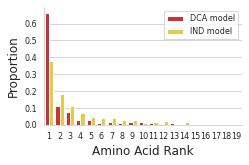

In [50]:
aa_site_df_1 = aa_site_df[['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank_DCA']]
aa_site_df_1.columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank']
aa_site_df_1["Model"] = "DCA model"
aa_site_df_2 = aa_site_df[['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank_Ind']]
aa_site_df_2.columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank']
aa_site_df_2["Model"] = "IND model"
aa_site_df_1 = pd.concat([aa_site_df_1,aa_site_df_2])
aa_site_df_2 = None
aa_site_df_1 = aa_site_df_1[aa_site_df_1["Reference"]]
tot = len(aa_site_df_1[aa_site_df_1["Model"]=="DCA model"])
aa_site_df_1 = aa_site_df_1.groupby(["Rank","Model"]).size().reset_index()
aa_site_df_1.columns = ["Rank","Model","Nb"]
aa_site_df_1["Prop"] = aa_site_df_1["Nb"]/tot
aa_site_df_1["Rank"] = aa_site_df_1["Rank"]+1

with sns.axes_style("whitegrid"):
    parameters()  
    fig = sns.catplot(x="Rank", y="Prop", hue="Model", kind="bar", data=aa_site_df_1, height=WIDTH*HW_RATIO, palette=[color_dca,color_ind], alpha=1, aspect=1/HW_RATIO, legend_out=False)
    plt.legend(loc='upper right')
    fig.set_axis_labels("Amino Acid Rank","Proportion")
    fig.savefig(Figures_folder / "Fig_1a.jpeg", dpi=DPI, bbox_inches="tight")

print(f"1st rank DCA: {aa_site_df_1[(aa_site_df_1['Rank']==1) & (aa_site_df_1['Model']=='DCA model')].loc[0,'Prop']}")
print(f"1st rank IND: {aa_site_df_1[(aa_site_df_1['Rank']==1) & (aa_site_df_1['Model']=='IND model')].loc[1,'Prop']}")

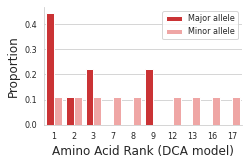

In [51]:
aa_site_df_1 = aa_site_df[['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank_DCA']]
aa_site_df_1.columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank']
aa_site_df_1["Model"] = "DCA"
aa_site_df_2 = aa_site_df[['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank_Ind']]
aa_site_df_2.columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank']
aa_site_df_2["Model"] = "Independent"
aa_site_df_1 = pd.concat([aa_site_df_1,aa_site_df_2])
aa_site_df_2 = None
aa_site_df_1 = aa_site_df_1[(~aa_site_df_1["Reference"]) & (aa_site_df_1["Observed"]>0.05)]
tot = len(aa_site_df_1[aa_site_df_1["Model"]=="DCA"])
aa_site_df_1 = aa_site_df_1.groupby(["Rank","Model"]).size().reset_index()
aa_site_df_1.columns = ["Rank","Model","Nb"]
aa_site_df_1["Prop"] = aa_site_df_1["Nb"]/tot
aa_site_df_1["Rank"] = aa_site_df_1["Rank"]+1

polymorphism = aa_site_df[(aa_site_df["Observed"]>0.05) & (aa_site_df["Observed"]<=0.5)][["Gene","Locus","Rank_DCA"]] # & (aa_site_df["CD_Entropy"]<3)
consensus = aa_site_df[aa_site_df["Observed"]>0.5][["Gene","Locus","Rank_DCA"]]
consensus = polymorphism[["Gene","Locus"]].merge(consensus,how="inner")
polymorphism["Cat"] = "Minor allele"
polymorphism["Total"] = len(polymorphism)
consensus["Cat"] = "Major allele"
consensus["Total"] = len(consensus)
polymorphism = pd.concat([polymorphism, consensus])
consensus = None
polymorphism = polymorphism.groupby(["Rank_DCA","Cat","Total"]).size().reset_index()
polymorphism.columns = ["Rank_DCA","Allele","Total","Nb"]
polymorphism["Prop"] = polymorphism["Nb"]/polymorphism["Total"]
polymorphism["Rank_DCA"] = polymorphism["Rank_DCA"]+1
polymorphism.head()
with sns.axes_style("whitegrid"):
    parameters() 
    fig = sns.catplot(x="Rank_DCA", y="Prop", hue="Allele", kind="bar", data=polymorphism, height=WIDTH*HW_RATIO,
                      palette=[sns.color_palette("Paired")[5],sns.color_palette("Paired")[4]], alpha=1, aspect=1/HW_RATIO, legend_out=False)
    fig.set_axis_labels("Amino Acid Rank (DCA model)","Proportion")
    plt.legend(loc='upper right')
    fig.savefig(Figures_folder / "Fig_1b.jpeg", dpi=DPI, bbox_inches="tight")

In [52]:
polymorphism_dca = polymorphism
polymorphism_dca = polymorphism_dca.rename(columns={"Rank_DCA":"Rank"})
polymorphism_dca["Model"] = "DCA"

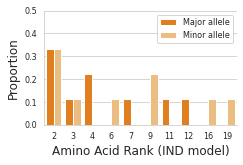

In [53]:
aa_site_df_1 = aa_site_df[['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank_DCA']]
aa_site_df_1.columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank']
aa_site_df_1["Model"] = "DCA"
aa_site_df_2 = aa_site_df[['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank_Ind']]
aa_site_df_2.columns = ['Gene', 'Locus', 'CD_Entropy', 'Reference', 'AA', 'Observed', 'Profile', 'Accessible', 'DCA_score', 'Rank']
aa_site_df_2["Model"] = "Independent"
aa_site_df_1 = pd.concat([aa_site_df_1,aa_site_df_2])
aa_site_df_2 = None
aa_site_df_1 = aa_site_df_1[(~aa_site_df_1["Reference"]) & (aa_site_df_1["Observed"]>0.05)]
tot = len(aa_site_df_1[aa_site_df_1["Model"]=="IND"])
aa_site_df_1 = aa_site_df_1.groupby(["Rank","Model"]).size().reset_index()
aa_site_df_1.columns = ["Rank","Model","Nb"]
aa_site_df_1["Prop"] = aa_site_df_1["Nb"]/tot
aa_site_df_1["Rank"] = aa_site_df_1["Rank"]+1

polymorphism = aa_site_df[(aa_site_df["Observed"]>0.05) & (aa_site_df["Observed"]<=0.5)][["Gene","Locus","Rank_Ind"]] # & (aa_site_df["CD_Entropy"]<3)
consensus = aa_site_df[aa_site_df["Observed"]>0.5][["Gene","Locus","Rank_Ind"]]
consensus = polymorphism[["Gene","Locus"]].merge(consensus,how="inner")
polymorphism["Cat"] = "Minor allele"
polymorphism["Total"] = len(polymorphism)
consensus["Cat"] = "Major allele"
consensus["Total"] = len(consensus)
polymorphism = pd.concat([polymorphism, consensus])
consensus = None
polymorphism = polymorphism.groupby(["Rank_Ind","Cat","Total"]).size().reset_index()
polymorphism.columns = ["Rank_Ind","Allele","Total","Nb"]
polymorphism["Prop"] = polymorphism["Nb"]/polymorphism["Total"]
polymorphism["Rank_Ind"] = polymorphism["Rank_Ind"]+1
with sns.axes_style("whitegrid"):
    parameters() 
    fig = sns.catplot(x="Rank_Ind", y="Prop", hue="Allele", kind="bar", data=polymorphism, height=WIDTH*HW_RATIO,
                      palette=[sns.color_palette("Paired")[7],sns.color_palette("Paired")[6]], alpha=1, aspect=1/HW_RATIO, legend_out=False)
    fig.set_axis_labels("Amino Acid Rank (IND model)","Proportion")
    plt.ylim((0,0.5))
    plt.legend(loc='upper right')
    fig.savefig(Figures_folder / "Fig_1b_ind.jpeg", dpi=DPI, bbox_inches="tight")

In [54]:
polymorphism_ind = polymorphism
polymorphism_ind = polymorphism_ind.rename(columns={"Rank_Ind":"Rank"})
polymorphism_ind["Model"] = "IND"

In [55]:
polymorphism = pd.concat([polymorphism_dca, polymorphism_ind])
polymorphism.head()

,Rank,Allele,Total,Nb,Prop,Model
0,1,Major allele,9,4,0.444444,DCA
1,1,Minor allele,9,1,0.111111,DCA
2,2,Major allele,9,1,0.111111,DCA
3,2,Minor allele,9,1,0.111111,DCA
4,3,Major allele,9,2,0.222222,DCA


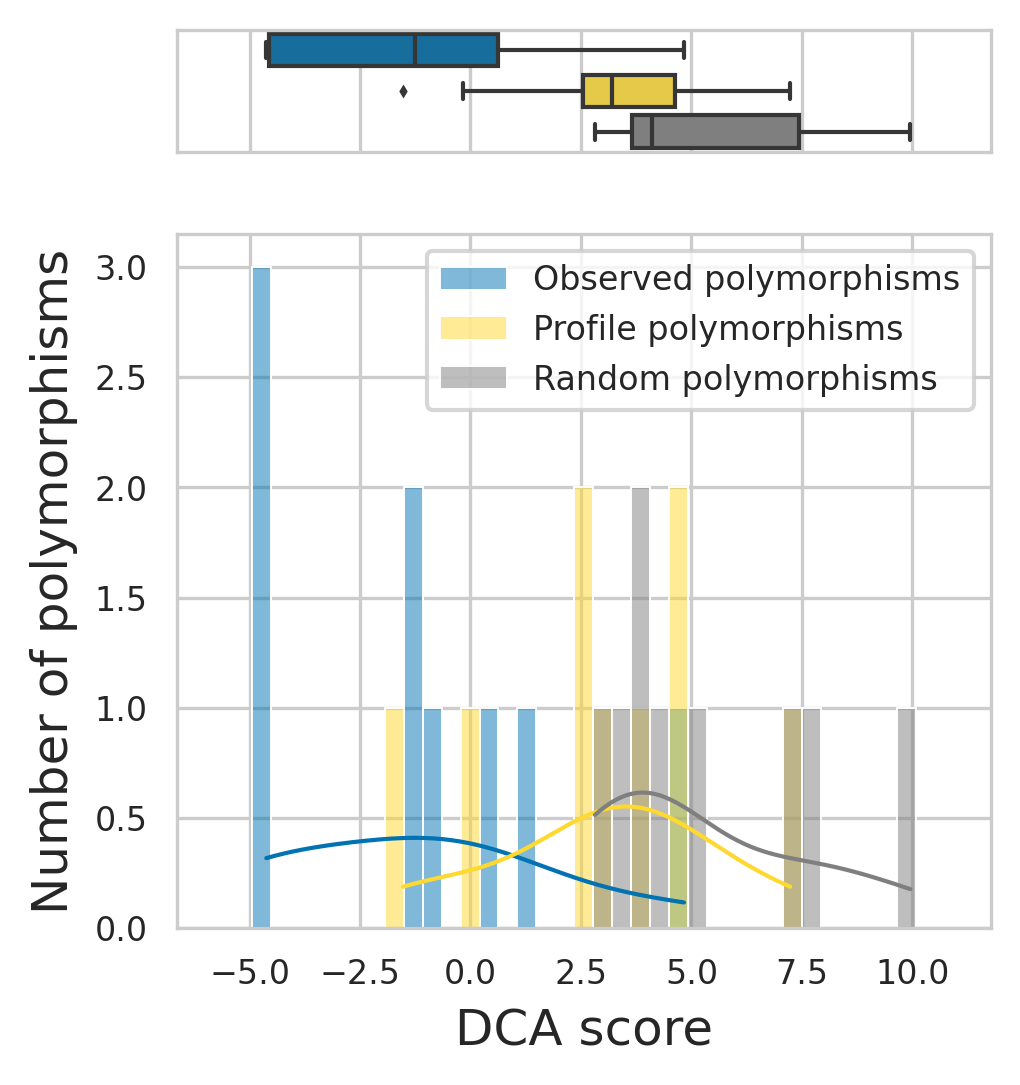

In [56]:
th_poly = 0.05
epsilon = 0.01

aa_site_df_1 = aa_site_df[~aa_site_df["Reference"]]
aa_site_df_1["Proba"] = aa_site_df_1["Profile"]/aa_site_df_1["Profile"].sum()
N = len(aa_site_df[(~aa_site_df["Reference"]) & (aa_site_df["Observed"]>th_poly)])
DCA = list(aa_site_df[(~aa_site_df["Reference"]) & (aa_site_df["Observed"]>th_poly)]["DCA_score"])
DCA += list(aa_site_df_1.sample(n=N, replace=False, weights="Proba")["DCA_score"])
DCA += list(aa_site_df[(~aa_site_df["Reference"])].sample(n=N, replace=False)["DCA_score"])
Label = ["Obs"]*N + ["Profile"]*N + ["Random"]*N
df = pd.DataFrame({"DCA":DCA, "Label":Label})

min_, max_ = aa_site_df["DCA_score"].min()-epsilon, aa_site_df["DCA_score"].max()+epsilon
bins = np.linspace(min_,max_,40)

with sns.axes_style("whitegrid"):
    parameters()   
    fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(WIDTH,WIDTH*HW_RATIO*1.7), sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, dpi=DPI)
    sns.boxplot(x="DCA", y="Label", order=["Obs", "Profile", "Random"], palette=[color_variable, color_ind, color_rand], data=df, ax=ax_box, linewidth=linewidth, fliersize=linewidth)
    sns.histplot(data=df[(df["Label"]=="Obs")], x="DCA", color=color_variable, kde=True, label="Observed polymorphisms",ax=ax_hist,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=df[(df["Label"]=="Profile")], x="DCA", color=color_ind, kde=True, label="Profile polymorphisms",ax=ax_hist,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=df[(df["Label"]=="Random")], x="DCA", color=color_rand, kde=True, label="Random polymorphisms",ax=ax_hist,bins=bins,line_kws={"linewidth":linewidth})
    ax_box.set(xlabel='')
    ax_box.set(ylabel='')
    ax_box.set_yticks([])
    ax_hist.set_xlabel("DCA score")
    ax_hist.set_ylabel("Number of polymorphisms")
    #ax_hist.set_ylim((0,500))
    plt.legend(loc='upper right')   
    fig.savefig(Figures_folder / "Fig_1c.jpeg", dpi=DPI, bbox_inches="tight")

0.11810582838757366
0.08292571577643004


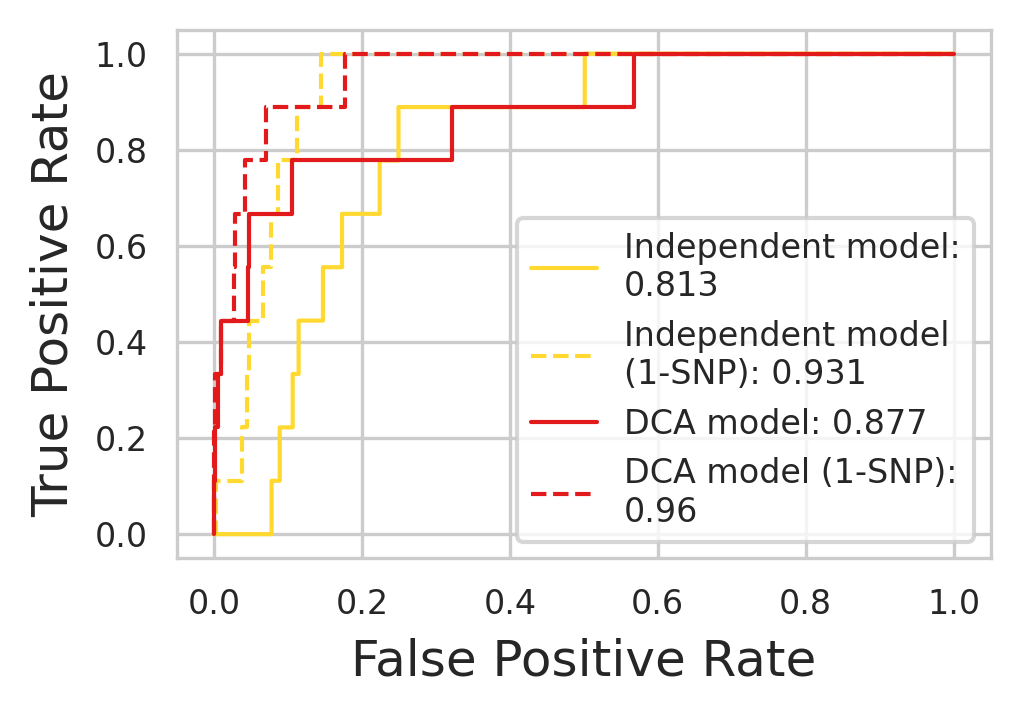

In [57]:
df = aa_site_df[((aa_site_df["Observed"]>th_poly) | (aa_site_df["Observed"]==0)) & (~aa_site_df["Reference"])] 
df = df[~df["Gene"].isin(['PF00033-GA4805AA_01620', 'PF01306-GA4805AA_02748', 'PF04403-GA4805AA_01031'])]
print(roc_auc_score((df["Observed"]>th_poly).astype(int), df["acc_Profile"])-roc_auc_score((df["Observed"]>th_poly).astype(int), df["Profile"]))
print(roc_auc_score((df["Observed"]>th_poly).astype(int), df["acc_DCA_Proba"])-roc_auc_score((df["Observed"]>th_poly).astype(int), df["DCA_Proba"]))


with sns.axes_style("whitegrid"):
    parameters()
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO), dpi=DPI)
    ax = fig.add_subplot(111)

    fpr, tpr, threshold = roc_curve((df["Observed"]>th_poly).astype(int), df["Profile"])
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot(ax=ax, label="Independent model:\n{}".format(np.round(roc_auc_score((df["Observed"]>th_poly).astype(int), df["Profile"]),3)), color=color_ind, linewidth=linewidth) 

    fpr, tpr, threshold = roc_curve((df["Observed"]>th_poly).astype(int), df["acc_Profile"])
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot(ax=ax, label="Independent model\n(1-SNP): {}".format(np.round(roc_auc_score((df["Observed"]>th_poly).astype(int), df["acc_Profile"]),3)), color=color_ind, linestyle="--", linewidth=linewidth)

    fpr, tpr, threshold = roc_curve((df["Observed"]>th_poly).astype(int), df["DCA_Proba"])
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot(ax=ax, label="DCA model: {}".format(np.round(roc_auc_score((df["Observed"]>th_poly).astype(int), df["DCA_Proba"]),3)), color=color_dca, linewidth=linewidth)

    fpr, tpr, threshold = roc_curve((df["Observed"]>th_poly).astype(int), df["acc_DCA_Proba"])
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot(ax=ax, label="DCA model (1-SNP):\n{}".format(np.round(roc_auc_score((df["Observed"]>th_poly).astype(int), df["acc_DCA_Proba"]),3)), color=color_dca, linestyle="--", linewidth=linewidth) 
    fig.savefig(Figures_folder / "Fig_S2.jpeg", dpi=DPI, bbox_inches="tight")

## Subsection 3

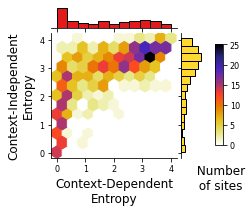

In [58]:
fig = sns.jointplot(x="CD_Entropy",y="CI_Entropy",data=stats_df,kind="hex",cmap='CMRmap_r',height=WIDTH) #cubehelix_r, gist_earth_r, afmhot_r, hot_r, gnuplot2_r

for patch in fig.ax_marg_x.patches:
    patch.set_facecolor(color_dca)
for patch in fig.ax_marg_y.patches:
    patch.set_facecolor(color_ind)

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 
cbar_ax = fig.fig.add_axes([.85, .25, .03, .4])
cbar_ax.set_xlabel('\n Number\n of sites')
plt.colorbar(cax=cbar_ax)
    
fig.set_axis_labels("Context-Dependent\nEntropy","Context-Independent\nEntropy")
fig.savefig(Figures_folder / "Fig_2b.jpeg", dpi=DPI, bbox_inches="tight")

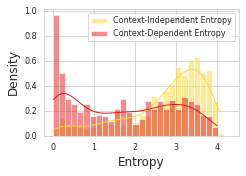

In [59]:
epsilon = 0.01
bins = np.linspace(0-epsilon,np.log2(20)+epsilon,30)

with sns.axes_style("whitegrid"):
    parameters()
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=stats_df, x="CI_Entropy", kde=True,stat="density",color=color_ind,label="Context-Independent Entropy",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df, x="CD_Entropy", kde=True,stat="density",color=color_dca,label="Context-Dependent Entropy",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    ax.set_xlabel("Entropy")
    plt.legend()
    fig.savefig(Figures_folder / "Fig_2c.jpeg", dpi=DPI, bbox_inches="tight")

In [60]:
print(len(stats_df[stats_df["CI_Entropy"]<1])/len(stats_df))
print(len(stats_df[stats_df["CD_Entropy"]<1])/len(stats_df))

0.08199643493761141
0.38324420677361853


## Subsection 4

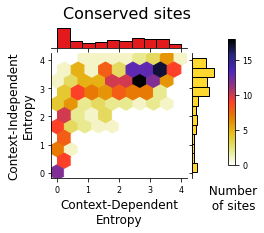

In [61]:
fig = sns.jointplot(x="CD_Entropy",y="CI_Entropy",data=stats_df[stats_df["Freq"]==0],kind="hex",cmap='CMRmap_r',height=WIDTH) #cubehelix_r, gist_earth_r, afmhot_r, hot_r, gnuplot2_r

for patch in fig.ax_marg_x.patches:
    patch.set_facecolor(color_dca)
for patch in fig.ax_marg_y.patches:
    patch.set_facecolor(color_ind)
    
plt.subplots_adjust(left=0.2, right=0.85, top=0.9, bottom=0.3) 
cbar_ax = fig.fig.add_axes([.9, .35, .03, .5])
cbar_ax.set_xlabel('\n Number\n of sites')
plt.colorbar(cax=cbar_ax)
    
fig.set_axis_labels("Context-Dependent\nEntropy","Context-Independent\nEntropy")
fig.fig.suptitle("Conserved sites")
fig.savefig(Figures_folder / "Fig_3a.jpeg", dpi=DPI, bbox_inches="tight")

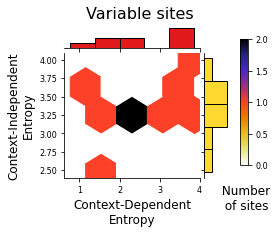

In [62]:
fig = sns.jointplot(x="CD_Entropy",y="CI_Entropy",data=stats_df[stats_df["Freq"]>0.05],kind="hex",cmap='CMRmap_r',height=WIDTH) #cubehelix_r, gist_earth_r, afmhot_r, hot_r, gnuplot2_r

for patch in fig.ax_marg_x.patches:
    patch.set_facecolor(color_dca)
for patch in fig.ax_marg_y.patches:
    patch.set_facecolor(color_ind)
    
plt.subplots_adjust(left=0.2, right=0.85, top=0.9, bottom=0.3) 
cbar_ax = fig.fig.add_axes([.9, .35, .03, .5])
cbar_ax.set_xlabel('\n Number\n of sites')
plt.colorbar(cax=cbar_ax)
    
fig.set_axis_labels("Context-Dependent\nEntropy","Context-Independent\nEntropy")
fig.fig.suptitle("Variable sites")
fig.savefig(Figures_folder / "Fig_3b.jpeg", dpi=DPI, bbox_inches="tight")

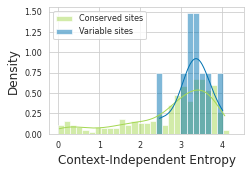

In [63]:
epsilon = 0.01
bins = np.linspace(0-epsilon,np.log2(20)+epsilon,30)

with sns.axes_style("whitegrid"):
    parameters()
    fig = plt.figure(figsize=(WIDTH, WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=stats_df[stats_df["Freq"]==0], x="CI_Entropy", kde=True,stat="density",color=color_conserved,label="Conserved sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df[stats_df["Freq"]>0.05], x="CI_Entropy", kde=True,stat="density",color=color_variable,label="Variable sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})

    ax.set_xlabel("Context-Independent Entropy")
    plt.legend()
    fig.savefig(Figures_folder / "Fig_3c.jpeg", dpi=DPI, bbox_inches="tight")

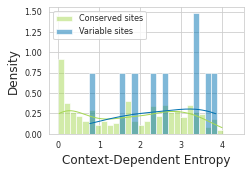

In [64]:
epsilon = 0.01
bins = np.linspace(0-epsilon,np.log2(20)+epsilon,30)

with sns.axes_style("whitegrid"):
    parameters()
    fig = plt.figure(figsize=(WIDTH, WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=stats_df[stats_df["Freq"]==0], x="CD_Entropy", kde=True,stat="density",color=color_conserved,label="Conserved sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df[stats_df["Freq"]>0.05], x="CD_Entropy", kde=True,stat="density",color=color_variable,label="Variable sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})

    ax.set_xlabel("Context-Dependent Entropy")
    plt.legend()
    fig.savefig(Figures_folder / "Fig_3d.jpeg", dpi=DPI, bbox_inches="tight")

In [65]:
th = 1

def entropy(x):
    if(x>0):
        return -x*np.log2(x)
    return 0

aa_site_df_1 = aa_site_df
aa_site_df_1["acc_CI"] = aa_site_df_1["acc_Profile"].apply(entropy)
aa_site_df_1["acc_CD"] = aa_site_df_1["acc_DCA_Proba"].apply(entropy)
aa_site_df_1 = aa_site_df_1[["Gene","Locus","acc_CI","acc_CD"]].groupby(["Gene","Locus"]).sum().reset_index()
df = stats_df[stats_df["Freq"]==0].merge(aa_site_df_1,on=["Gene","Locus"],how="inner")
print(len(df[(df["acc_CD"]<th)])/len(df))
print(len(df[(df["acc_CI"]<th)])/len(df))
df = None

print(len(stats_df[(stats_df["CI_Entropy"]<th) & (stats_df["Freq"]==0)])/len(stats_df[(stats_df["Freq"]==0)]))
print(len(stats_df[(stats_df["CD_Entropy"]<th) & (stats_df["Freq"]==0)])/len(stats_df[(stats_df["Freq"]==0)]))

0.4966442953020134
0.15436241610738255
0.09060402684563758
0.348993288590604


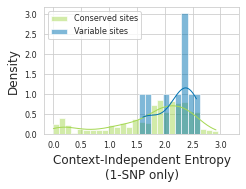

In [66]:
epsilon = 0.01
bins = np.linspace(0-epsilon,np.log2(9)+epsilon,30)

with sns.axes_style("whitegrid"):
    parameters()
    fig = plt.figure(figsize=(WIDTH, WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=stats_df[stats_df["Freq"]==0].merge(aa_site_df_1,on=["Gene","Locus"]), x="acc_CI", kde=True,stat="density",color=color_conserved,label="Conserved sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df[stats_df["Freq"]>0.05].merge(aa_site_df_1,on=["Gene","Locus"]), x="acc_CI", kde=True,stat="density",color=color_variable,label="Variable sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})

    ax.set_xlabel("Context-Independent Entropy\n(1-SNP only)")
    plt.legend()
    fig.savefig(Figures_folder / "Fig_S5a.jpeg", dpi=DPI, bbox_inches="tight")

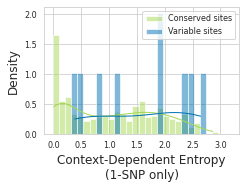

In [67]:
epsilon = 0.01
bins = np.linspace(0-epsilon,np.log2(9)+epsilon,30)

with sns.axes_style("whitegrid"):
    parameters()
    fig = plt.figure(figsize=(WIDTH, WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=stats_df[stats_df["Freq"]==0].merge(aa_site_df_1,on=["Gene","Locus"]), x="acc_CD", kde=True,stat="density",color=color_conserved,label="Conserved sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df[stats_df["Freq"]>0.05].merge(aa_site_df_1,on=["Gene","Locus"]), x="acc_CD", kde=True,stat="density",color=color_variable,label="Variable sites",ax=ax,bins=bins,line_kws={"linewidth":linewidth})

    ax.set_xlabel("Context-Dependent Entropy\n(1-SNP only)")
    plt.legend()
    fig.savefig(Figures_folder / "Fig_S5b.jpeg", dpi=DPI, bbox_inches="tight")

## Subsection 5

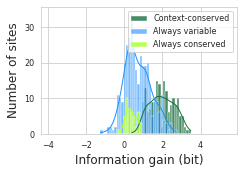

In [68]:
th = 1
epsilon = 0.01

bins = np.linspace(stats_df["IG"].min()-epsilon,stats_df["IG"].max()+epsilon,40)

with sns.axes_style("whitegrid"):
    parameters()  
    fig = plt.figure(figsize=(WIDTH, WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=stats_df[(stats_df["CI_Entropy"]>=th) & (stats_df["CD_Entropy"]<th)], x="IG", kde=True,color=color_cont_conserved, alpha=0.8,label="Context-conserved",ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df[(stats_df["CD_Entropy"]>=th)], x="IG", kde=True,color=color_alw_var,label="Always variable",alpha=0.6,ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    sns.histplot(data=stats_df[(stats_df["CI_Entropy"]<th)], x="IG", kde=True,color=color_alw_conserved,label="Always conserved",alpha=0.8,ax=ax,bins=bins,line_kws={"linewidth":linewidth})
    ax.set_xlabel("Information gain (bit)")
    ax.set_ylabel("Number of sites")
    #ax.set_ylim(0,25000)
    ax.set_xlim(-4.35,5.9)
    plt.legend(loc='upper right')
    fig.savefig(Figures_folder / "Fig_4b.jpeg", dpi=DPI, bbox_inches="tight")

In [69]:
th =1
print(len(stats_df[(stats_df["CI_Entropy"]<th)])/len(stats_df))
print(len(stats_df[(stats_df["CI_Entropy"]>=th) & (stats_df["CD_Entropy"]>=th)])/len(stats_df))
print(len(stats_df[(stats_df["CI_Entropy"]>=th) & (stats_df["CD_Entropy"]<th)])/len(stats_df))
print(len(stats_df[stats_df["IG"]>1])/len(stats_df))

0.08199643493761141
0.6149732620320856
0.30303030303030304
0.49910873440285203


## Subsection 6

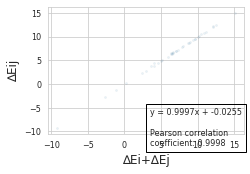

In [70]:
pearson, _ = scipy.stats.pearsonr(double_muts["Sum_single_mut"], double_muts["Double_mut"])
slope, intercept, _, _, _ = scipy.stats.linregress(double_muts["Sum_single_mut"], double_muts["Double_mut"])
with sns.axes_style("whitegrid"):
    parameters() 
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    #ax.plot("Sum_single_mut","Double_mut",".",data=double_muts, alpha=0.5)
    sns.scatterplot(data=double_muts, x="Sum_single_mut", y="Double_mut", ax=ax, ec="k",s=5, alpha=0.1)
    #ax.plot([-19.9,23],[-19.9,23],"--",color="w",linewidth=1)
    ax.set_xlabel("∆Ei+∆Ej")
    ax.set_ylabel("∆Eij")
    plt.text(3.5, -13, f"y = {slope:.4f}x + {intercept:.4f}\n\nPearson correlation\ncoefficient: {pearson:.4f}", bbox=dict(fill=False, edgecolor='k', linewidth=1))
    fig.savefig(Figures_folder / "Fig_5a_modif.jpeg", dpi=DPI, bbox_inches="tight")

0.27262875588387564


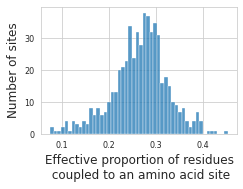

In [71]:
print(ipr_df["Neff"].median())
with sns.axes_style("whitegrid"):
    parameters() 
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=ipr_df, x="Neff",bins=50)
    ax.set_xlabel("Effective proportion of residues\n coupled to an amino acid site")
    ax.set_ylabel("Number of sites")
    fig.savefig(Figures_folder / "Fig_5b.jpeg", dpi=DPI, bbox_inches="tight")

## Subsection 7

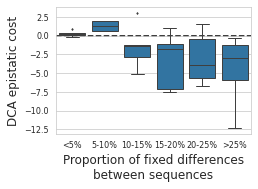

In [72]:
with sns.axes_style("whitegrid"):
    parameters()  
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    ax.plot([-0.5,6],[0,0],"--",color="k",zorder=0)
    sns.boxplot(x="Cat", y="Diff", data=full_seq_df, ax=ax, color=sns.color_palette()[0],linewidth=linewidth, fliersize=linewidth)
    ax.set_xlabel("Proportion of fixed differences\nbetween sequences")
    ax.set_ylabel("DCA epistatic cost")
    fig.savefig(Figures_folder / "Fig_6b.jpeg", dpi=DPI, bbox_inches="tight")

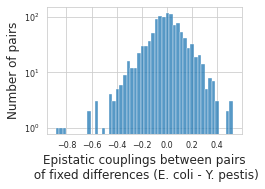

In [73]:
with sns.axes_style("whitegrid"):
    parameters() 
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_subplot(111)
    sns.histplot(data=couplings_df, x="Coupling",bins=50)
    ax.set_xlabel("Epistatic couplings between pairs\n of fixed differences (E. coli - Y. pestis)")
    ax.set_ylabel("Number of pairs")
    ax.set_yscale('log')
    fig.savefig(Figures_folder / "Fig_6c.jpeg", dpi=DPI, bbox_inches="tight")

## Simulations

In [74]:
def clean_stats_df(df):
    '''
    Filter rows in stats file before plotting figures.
    '''
    ## Filter sites where reference AA is major allele
    df = df[df["Context_freq"]>0.5]
    ## Filter sites where there's at least one possible synonymous mutation
    df = df[(df["Total_acc_syn"]>0)]
    ## Compute normalization of observed accessible probability
    df["Proba_obs_acc_norm"] = df["Proba_obs_acc"]/df["Proba_tot_acc"]
    ## Compute proportion of observed synonymous mutations
    df["Prop_syn"] = df["Observed_acc_syn"]/df["Total_acc_syn"]
    return df

def clean_simulated_sites_df(stats_df,simulated_sites_df):
    '''
    Keep same genes and loci than stats file, compute probability of reference AA.
    '''
    simulated_sites_df = stats_df[["Gene","Locus"]].merge(simulated_sites_df,how="left")
    simulated_sites_df["Ref_proba"] = simulated_sites_df["Proba"]/simulated_sites_df["Acceptance_th"] - simulated_sites_df["Proba"]
    return simulated_sites_df[~simulated_sites_df["Proba"].isna()]

stats_df_1 = clean_stats_df(stats_df)
simulated_sites = clean_simulated_sites_df(stats_df_1, pd.read_csv(simulated_sites_df_path))

lambda_list = [i/10 for i in range(20,51)]
nsim = 20
M = len(stats_df_1[(stats_df_1["Total_acc_syn"]==4)]["Prop_syn"])
values = stats_df_1[(stats_df_1["Total_acc_syn"]==4)].groupby("Prop_syn").size().reset_index()[0]

## JC69 simulation

def syn_simulation(lambda_list, nsim, M):
    '''
    Simulate synonymous mutations on 4-fold degenerate sites.
    '''
    probabilities = [1/3]*3
    Total = dict()
    for lambda_ in lambda_list:
        Total[lambda_] = list()
        for i in range(nsim):
            total = [0 for i in range(4)]
            N_list = np.random.poisson(lambda_,M)
            for j in range(M):
                sample = [1]
                values = np.random.choice([i+2 for i in range(len(probabilities))], N_list[j], p=probabilities)
                for value in values:
                    if((value not in sample) and (random.randint(1, 2)==1)):
                        sample.append(value)
                total[len(sample)-1] += 1
            Total[lambda_].append(total)
    return Total

def square_loss(Total, values):
    '''
    Compute and plot square loss to find optimal lambda parameter on simulations of synonymous mutants.
    '''
    avg = dict()
    X = list()
    Y = list()
    Z = list()
    val = np.sum(values*np.array([1,2,3,4]))/np.sum(values)
    for key in Total:
        avg[key] = list()
        for i in Total[key]:
            avg[key].append(np.sum(np.square(np.array(i)-values)))
        X.append(key)
        Y.append(np.mean(np.array(avg[key])))
        Z.append(np.std(np.array(avg[key])))
    lambda_ = X[np.argmin(np.array(Y))]
    mean_values = [list() for i in range(4)]
    for i in Total[lambda_]:
        for j in range(4):
            mean_values[j].append(i[j])
    for k in range(4):
        mean_values[k] = np.mean(mean_values[k])
    return X, Y, Z, mean_values 

syn_sim_results = square_loss(syn_simulation(lambda_list, nsim, M), values)
pd.DataFrame({"X":syn_sim_results[0],"Y":syn_sim_results[1],"Z":syn_sim_results[2]}).to_csv(Data_folder / "syn_sim_results_1.csv",index=None)
pd.DataFrame({"Real_values":values,"Sim_values":syn_sim_results[3]}).to_csv(Data_folder / "synsim_results_2.csv",index=None)

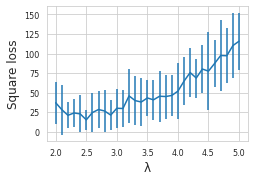

In [75]:
with sns.axes_style("whitegrid"):
    parameters()  
    X, Y, Z, mean_values = syn_sim_results
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.errorbar(X, Y, yerr=Z, label='both limits (default)')
    ax.set_xlabel("λ")
    ax.set_ylabel("Square loss")
    fig.savefig(Figures_folder / "Fig_S3a.jpeg", dpi=DPI, bbox_inches="tight")

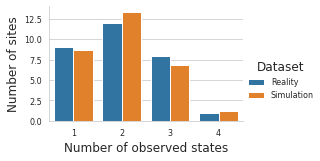

In [76]:
df = pd.DataFrame({"Nb_mut":[1,2,3,4,1,2,3,4],"Dataset":["Reality"]*4+["Simulation"]*4,
                  "Nb_site":list(values)+list(mean_values)})

with sns.axes_style("whitegrid"):
    parameters()  
    fig = sns.catplot(x="Nb_mut", y="Nb_site", hue="Dataset", kind="bar", data=df, height=WIDTH*HW_RATIO, alpha=1, aspect=1/HW_RATIO)
    fig.set_axis_labels("Number of observed states","Number of sites")
    fig.savefig(Figures_folder / "Fig_S3b.jpeg", dpi=DPI, bbox_inches="tight")

del df

In [77]:
def aa_simulation(stats,simulated_sites_df,lambda_):
    '''
    Simulate new (non-synonymous) mutations using the given lambda parameter.
    '''
    Total_proba = list()
    Conserved = list()
    for index, row in stats.iterrows():
        df = simulated_sites_df[(simulated_sites_df["Gene"]==row['Gene']) & (simulated_sites_df["Locus"]==row['Locus'])]
        counts = np.array(list(df["Counts"]))
        probabilities = list((counts)/counts.sum())
        thresholds = list(df["Acceptance_th"])
        AA = list(df["AA"])
        ref = list(df["Ref"])[0]
        ref_id = -1
        if(ref in AA):
            ref_id = AA.index(ref)
        N = np.random.poisson(lambda_,1)
        sample = np.random.choice([i for i in range(len(probabilities))], N, p=probabilities)
        accept = [np.random.random(1)[0]<thresholds[i] for i in sample]
        accepted_AA = list(np.unique([sample[i] for i in range(len(accept)) if accept[i]]))
        if(ref_id in accepted_AA):
            accepted_AA.remove(ref_id)
        accepted_AA = np.array(accepted_AA)
        proba = list(df["Proba"])
        Total_proba.append(np.sum([proba[i] for i in accepted_AA])+list(df["Ref_proba"])[0])
        Conserved.append(len(accepted_AA)==0)
    stats["Total_proba"] = Total_proba
    stats["Conserved"] = Conserved
    return stats[["Gene","Locus","Total_proba","Conserved"]]

X = syn_sim_results[0]
Y = syn_sim_results[1]
lambda_JC69 = X[np.argmin(np.array(Y))]
simulated_aa_jc69 = aa_simulation(stats_df_1[stats_df_1["Locus"]>0],simulated_sites,lambda_JC69)
print(lambda_JC69)
simulated_aa_jc69.to_csv("simulated_aa_jc69.csv",index=None)
stats_df_1[stats_df_1["Locus"]>0].to_csv('stats_1.csv',index=None)

2.5


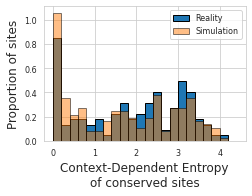

In [78]:
with sns.axes_style("whitegrid"):
    parameters()  
    selected_columns = ['Gene', 'Locus', 'Freq', 'CD_Entropy', 'CI_Entropy', 'Proba_obs_acc', 'Proba_tot_acc']
    simulations_df = stats_df_1[stats_df_1["Locus"]>0][selected_columns].merge(simulated_aa_jc69)
    fig = plt.figure(figsize=(WIDTH,WIDTH*HW_RATIO))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.hist(simulations_df[simulations_df["Freq"]==0]["CD_Entropy"],density=True,bins=[i/5 for i in range(23)], edgecolor='black', linewidth=1, alpha=1, label="Reality")
    ax.hist(simulations_df[simulations_df["Conserved"]]["CD_Entropy"],density=True,bins=[i/5 for i in range(23)], edgecolor='black', linewidth=1, alpha=0.5, label="Simulation")
    plt.legend()
    ax.set_xlabel("Context-Dependent Entropy\nof conserved sites")
    ax.set_ylabel("Proportion of sites")
    fig.savefig(Figures_folder / "Fig_S3c.jpeg", dpi=DPI, bbox_inches="tight")

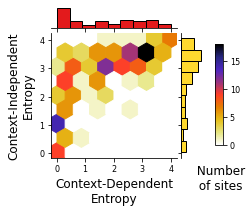

In [79]:
selected_columns = ['Gene', 'Locus', 'Freq', 'CD_Entropy', 'CI_Entropy', 'Proba_obs_acc', 'Proba_tot_acc']
simulations_df = stats_df_1[stats_df_1["Locus"]>0][selected_columns].merge(simulated_aa_jc69)
xlim = np.max(simulations_df["CD_Entropy"])+0.1
ylim = np.max(simulations_df["CI_Entropy"])+0.1
fig = sns.jointplot(x="CD_Entropy",y="CI_Entropy",data=simulations_df[simulations_df["Conserved"]],kind="hex",cmap='CMRmap_r',height=WIDTH)

for patch in fig.ax_marg_x.patches:
    patch.set_facecolor(color_dca)
for patch in fig.ax_marg_y.patches:
    patch.set_facecolor(color_ind)

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 
cbar_ax = fig.fig.add_axes([.85, .25, .03, .4])
cbar_ax.set_xlabel('\n Number\n of sites')
plt.colorbar(cax=cbar_ax)

fig.set_axis_labels("Context-Dependent\nEntropy","Context-Independent\nEntropy")
fig.savefig(Figures_folder / "Fig_S3d.jpeg", dpi=DPI, bbox_inches="tight")